In [ ]:
# First cell - Install just the required packages
!pip install torch>=1.7.0
!pip install torchvision>=0.9.1
!pip install omegaconf>=2.0.6
!pip install onnx>=1.7.0
!pip install pandas>=1.2.2
!pip install pyyaml>=5.3.1
!pip install tensorboard
!pip install future
!pip install scipy>=1.6.0
!pip install scikit-learn  # Modern replacement for sklearn

!pip install crypten --no-deps  # Install crypten without extra dependencies


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.9/259.9 kB 4.4 MB/s eta 0:00:00


In [ ]:
!pip install torch torchvision pandas scikit-learn matplotlib


**MPC ASL CODE**:
Running this code on a CPU can result in slower convergence and unstable results because of the way this code works. We add encryption noise so this code will not work correctly on a cpu. Please change runtime type to gpu before running. To ensure consistent performance, the code explicitly checks for a CUDA-capable GPU and throws an error if one is not available.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

class MediaPipePoseDataset(Dataset):
    def __init__(self, csv_file):
        self.positions = pd.read_csv(csv_file)
        self.char_to_int = {
            'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9,
            'L':10, 'M':11, 'N':12, 'O':13, 'P':14, 'Q':15, 'R':16, 'S':17, 'T':18,
            'U':19, 'V':20, 'W':21, 'X':22, 'Y':23
        }

    def __len__(self):
        return len(self.positions)

    def __getitem__(self, idx):
        data = self.positions.iloc[idx, 1:].values.astype('float32')
        character = self.positions.iloc[idx, 0]
        label = self.char_to_int[character]
        return data, label

class PrivateParty:
    def __init__(self, features, device):
        self.features = torch.tensor(features, dtype=torch.float32).to(device)

    def get_encrypted_features(self):
        # Simulate encryption by adding small random noise
        noise = torch.randn_like(self.features) * 1e-5
        return self.features + noise

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(39, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 24),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
def simulate_privacy_preserving_training():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    assert torch.cuda.is_available(), "CUDA-capable GPU is required to run this code. Please enable GPU in runtime settings."
    print(f"Using device: {device}")

    # Load and preprocess data
    train_dataset = MediaPipePoseDataset('Synthetic_Train_Features2.csv')
    test_dataset = MediaPipePoseDataset('Synthetic_Test_Features2.csv')

    # Convert to numpy arrays
    X_train = np.array([d[0] for d in train_dataset])
    y_train = np.array([d[1] for d in train_dataset])
    X_test = np.array([d[0] for d in test_dataset])
    y_test = np.array([d[1] for d in test_dataset])

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Split features vertically (simulating different parties)
    party1 = PrivateParty(X_train[:, :13], device)
    party2 = PrivateParty(X_train[:, 13:26], device)
    party3 = PrivateParty(X_train[:, 26:], device)

    # Get "encrypted" features from each party
    encrypted_features = torch.cat([
        party1.get_encrypted_features(),
        party2.get_encrypted_features(),
        party3.get_encrypted_features()
    ], dim=1)

    # Prepare labels
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

    # Initialize model
    model = NeuralNetwork().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training
    batch_size = 64
    num_epochs = 20
    train_loader = DataLoader(
        list(zip(encrypted_features, y_train_tensor)),
        batch_size=batch_size,
        shuffle=True
    )

    epoch_loss = []
    epoch_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == batch_labels).sum().item()
            total_samples += batch_labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct_predictions / total_samples * 100

        epoch_loss.append(avg_loss)
        epoch_accuracy.append(accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Save data for plotting
    np.save('epoch_loss.npy', epoch_loss)
    np.save('epoch_accuracy.npy', epoch_accuracy)

simulate_privacy_preserving_training()

Using device: cuda
Epoch 1/20, Loss: 0.2666, Accuracy: 92.71%
Epoch 2/20, Loss: 0.1372, Accuracy: 96.48%
Epoch 3/20, Loss: 0.1409, Accuracy: 96.75%
Epoch 4/20, Loss: 0.1108, Accuracy: 97.28%
Epoch 5/20, Loss: 0.1012, Accuracy: 97.62%
Epoch 6/20, Loss: 0.1050, Accuracy: 97.52%
Epoch 7/20, Loss: 0.1318, Accuracy: 97.31%
Epoch 8/20, Loss: 0.0827, Accuracy: 98.17%
Epoch 9/20, Loss: 0.0686, Accuracy: 98.42%
Epoch 10/20, Loss: 0.0990, Accuracy: 97.93%
Epoch 11/20, Loss: 0.1216, Accuracy: 97.46%
Epoch 12/20, Loss: 0.1503, Accuracy: 97.17%
Epoch 13/20, Loss: 0.0896, Accuracy: 98.14%
Epoch 14/20, Loss: 0.0689, Accuracy: 98.36%
Epoch 15/20, Loss: 0.0723, Accuracy: 98.45%
Epoch 16/20, Loss: 0.1485, Accuracy: 97.28%
Epoch 17/20, Loss: 0.1117, Accuracy: 97.78%
Epoch 18/20, Loss: 0.0765, Accuracy: 98.22%
Epoch 19/20, Loss: 0.0698, Accuracy: 98.53%
Epoch 20/20, Loss: 0.0662, Accuracy: 98.61%


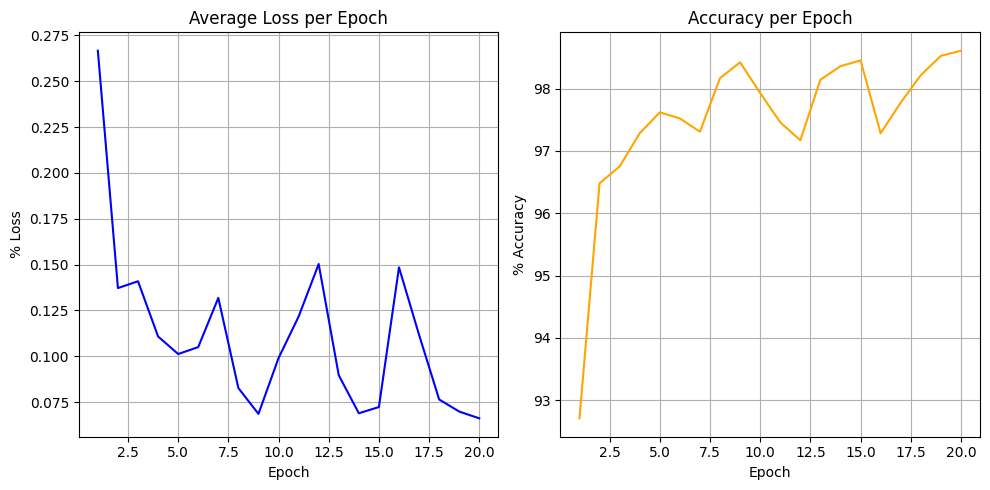

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load saved data
epoch_loss = np.load('epoch_loss.npy')
epoch_accuracy = np.load('epoch_accuracy.npy')
epochs = range(1, len(epoch_loss) + 1)

# Plotting the graphs
plt.figure(figsize=(10, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_loss, label='Loss', color='blue')
plt.title('Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('% Loss')
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_accuracy, label='Accuracy', color='orange')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('% Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


**Non Simulation MPC**

In [ ]:
# Install necessary libraries if needed
# !pip install crypten --no-deps
# !pip install pandas scikit-learn torch torchvision

import crypten
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

# Initialize CrypTen
crypten.init()

@crypten.mpc.run_multiprocess(world_size=3)
def train_mpc_model():
    # -----------------------
    # Dataset Class
    # -----------------------
    class MediaPipePoseDataset(Dataset):
        def __init__(self, csv_file):
            self.positions = pd.read_csv(csv_file)
            self.char_to_int = {
                'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9,
                'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18,
                'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23
            }

        def __len__(self):
            return len(self.positions)

        def __getitem__(self, idx):
            data = self.positions.iloc[idx, 1:].values.astype('float32')
            character = self.positions.iloc[idx, 0]
            label = self.char_to_int[character]
            return data, label

    # -----------------------
    # Load Dataset
    # -----------------------
    train_dataset = MediaPipePoseDataset('Synthetic_Train_Features2.csv')
    test_dataset = MediaPipePoseDataset('Synthetic_Test_Features2.csv')

    X_train = np.array([train_dataset[i][0] for i in range(len(train_dataset))])
    y_train = np.array([train_dataset[i][1] for i in range(len(train_dataset))])
    X_test = np.array([test_dataset[i][0] for i in range(len(test_dataset))])
    y_test = np.array([test_dataset[i][1] for i in range(len(test_dataset))])

    # -----------------------
    # Scaling Features
    # -----------------------
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # -----------------------
    # Split Data Vertically
    # -----------------------
    X_train_party1 = X_train[:, :13]
    X_train_party2 = X_train[:, 13:26]
    X_train_party3 = X_train[:, 26:]

    X_test_party1 = X_test[:, :13]
    X_test_party2 = X_test[:, 13:26]
    X_test_party3 = X_test[:, 26:]

    # -----------------------
    # One-Hot Encode Targets
    # -----------------------
    num_classes = 24

    def to_onehot(labels, num_classes):
        onehot = np.zeros((labels.shape[0], num_classes), dtype=np.float32)
        for i, c in enumerate(labels):
            onehot[i, c] = 1.0
        return onehot

    y_train_onehot = to_onehot(y_train, num_classes)
    y_test_onehot = to_onehot(y_test, num_classes)

    # -----------------------
    # Convert to Torch Tensors
    # -----------------------
    X_train_party1_tensor = torch.tensor(X_train_party1, dtype=torch.float32)
    X_train_party2_tensor = torch.tensor(X_train_party2, dtype=torch.float32)
    X_train_party3_tensor = torch.tensor(X_train_party3, dtype=torch.float32)

    y_train_tensor = torch.tensor(y_train_onehot, dtype=torch.float32)

    X_test_party1_tensor = torch.tensor(X_test_party1, dtype=torch.float32)
    X_test_party2_tensor = torch.tensor(X_test_party2, dtype=torch.float32)
    X_test_party3_tensor = torch.tensor(X_test_party3, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_onehot, dtype=torch.float32)

    # -----------------------
    # Encrypt Data
    # -----------------------
    encrypted_X_party1 = crypten.cryptensor(X_train_party1_tensor, src=0)
    encrypted_X_party2 = crypten.cryptensor(X_train_party2_tensor, src=1)
    encrypted_X_party3 = crypten.cryptensor(X_train_party3_tensor, src=2)
    encrypted_y_train = crypten.cryptensor(y_train_tensor, src=0)

    encrypted_X_train = crypten.cat([encrypted_X_party1, encrypted_X_party2, encrypted_X_party3], dim=1)

    # -----------------------
    # Define Model
    # -----------------------
    class NeuralNetwork(nn.Module):
        def __init__(self):
            super().__init__()
            self.flatten = nn.Flatten()
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(39, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 24),
            )

        def forward(self, x):
            x = self.flatten(x)
            logits = self.linear_relu_stack(x)
            return logits

    model = NeuralNetwork()
    example_input = torch.empty(1, 39)
    encrypted_model = crypten.nn.from_pytorch(model, example_input)
    encrypted_model.encrypt()

    # Loss function and learning rate
    loss_fn = crypten.nn.CrossEntropyLoss()
    crypten.encoder.fixed_point_precision = 64
    learning_rate = 0.1
    num_epochs = 20

    # Store loss and accuracy
    epoch_loss = []
    epoch_accuracy = []

    # -----------------------
    # Training
    # -----------------------
    for epoch in range(num_epochs):
        encrypted_model.train()
        predictions = encrypted_model(encrypted_X_train)
        loss = loss_fn(predictions, encrypted_y_train)
        encrypted_model.zero_grad()
        loss.backward()
        # learning_rate = learning_rate / (1 + epoch * 0.1)
        encrypted_model.update_parameters(learning_rate)

        train_loss_plain = loss.get_plain_text().item()
        epoch_loss.append(train_loss_plain)

        # Evaluation during training
        encrypted_model.eval()
        encrypted_X_test = crypten.cat([
            crypten.cryptensor(X_test_party1_tensor, src=0),
            crypten.cryptensor(X_test_party2_tensor, src=1),
            crypten.cryptensor(X_test_party3_tensor, src=2)
        ], dim=1)

        with torch.no_grad():
            test_predictions = encrypted_model(encrypted_X_test)
            decrypted_predictions = test_predictions.get_plain_text()

            predicted_classes = torch.argmax(decrypted_predictions, dim=1)
            true_classes = torch.argmax(y_test_tensor, dim=1)
            correct = (predicted_classes == true_classes).sum().item()
            accuracy = correct / len(true_classes) * 100
            epoch_accuracy.append(accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss_plain:.4f}, Accuracy: {accuracy:.2f}%")

    # Save metrics for plotting
    np.save('epoch_loss.npy', epoch_loss)
    np.save('epoch_accuracy.npy', epoch_accuracy)

train_mpc_model()


/usr/local/lib/python3.10/dist-packages/crypten/__init__.py:64: RuntimeWarning: CrypTen is already initialized.
  warnings.warn("CrypTen is already initialized.", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/crypten/nn/onnx_converter.py:176: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  param = torch.from_numpy(numpy_helper.to_array(node))
/usr/local/lib/python3.10/dist-packages/crypten/nn/onnx_converter.py:176: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array

Epoch 1/20, Loss: 3.1829, Accuracy: 4.10%Epoch 1/20, Loss: 3.1829, Accuracy: 4.10%
Epoch 1/20, Loss: 3.1829, Accuracy: 4.10%

Epoch 2/20, Loss: 3.1808, Accuracy: 4.90%Epoch 2/20, Loss: 3.1808, Accuracy: 4.90%

Epoch 2/20, Loss: 3.1808, Accuracy: 4.90%
Epoch 3/20, Loss: 3.1787, Accuracy: 5.88%Epoch 3/20, Loss: 3.1787, Accuracy: 5.88%

Epoch 3/20, Loss: 3.1787, Accuracy: 5.88%
Epoch 4/20, Loss: 3.1766, Accuracy: 6.86%Epoch 4/20, Loss: 3.1766, Accuracy: 6.86%
Epoch 4/20, Loss: 3.1766, Accuracy: 6.86%

Epoch 5/20, Loss: 3.1744, Accuracy: 7.65%Epoch 5/20, Loss: 3.1744, Accuracy: 7.65%

Epoch 5/20, Loss: 3.1744, Accuracy: 7.65%
Epoch 6/20, Loss: 3.1723, Accuracy: 8.40%Epoch 6/20, Loss: 3.1723, Accuracy: 8.40%

Epoch 6/20, Loss: 3.1723, Accuracy: 8.40%
Epoch 7/20, Loss: 3.1701, Accuracy: 8.96%Epoch 7/20, Loss: 3.1701, Accuracy: 8.96%

Epoch 7/20, Loss: 3.1701, Accuracy: 8.96%
Epoch 8/20, Loss: 3.1680, Accuracy: 9.42%Epoch 8/20, Loss: 3.1680, Accuracy: 9.42%
Epoch 8/20, Loss: 3.1680, Accuracy:

[None, None, None]

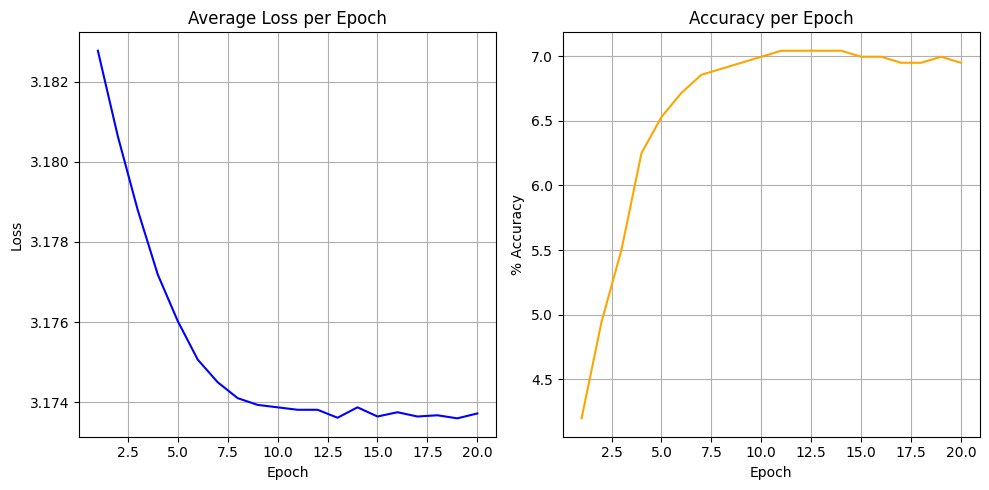

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load saved metrics
epoch_loss = np.load('epoch_loss.npy')
epoch_accuracy = np.load('epoch_accuracy.npy')
epochs = range(1, len(epoch_loss) + 1)

# Plotting
plt.figure(figsize=(10, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_loss, label='Loss', color='blue')
plt.title('Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_accuracy, label='Accuracy', color='orange')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('% Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()
